In [ ]:
import torch
import torch.nn as nn

# state space approximation of the underdamped spring-mass-damper system
class PhysicsInformedNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, m, c, k):
        super(PhysicsInformedNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
        # State space matrices for the underdamped spring
        self.A = torch.tensor([[0, 1], [-k/m, -c/m]], dtype=torch.float32)
        self.B = torch.tensor([[0], [1]], dtype=torch.float32)  # Assuming a zero input (free response)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def physics_loss(self, x):
        # x is the state vector
        dx = torch.matmul(self.A, x.T).T  # Calculate the state derivative
        return dx

# Example usage
m = 1.0  # Mass
c = 0.2  # Damping coefficient
k = 1.0  # Spring constant

model = PhysicsInformedNN(input_dim=2, hidden_dim=50, output_dim=2, m=m, c=c, k=k)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Dummy data (initial state and zero input for simplicity)
x = torch.randn(10, 2)

# Forward pass
output = model(x)

# Compute physics-based loss
loss = model.physics_loss(x).mean()  # Mean of the physics loss over the batch

loss


# Kolmorgorov-Arnold Network (KAN)

In [8]:
import numpy as np
import torch
import torch.optim as optim
import pimodels as pim
import pilosses as pil

# Initialize model, optimizer, and training parameters
model = pim.KAN(
            layers_hidden=[1, 50, 50, 1],  # Define the layer sizes
            grid_size=5,
            spline_order=3,
            scale_noise=0.1,
            scale_base=1.0,
            scale_spline=1.0,
            base_activation=torch.nn.Tanh,
            grid_eps=0.02,
            grid_range=[-1, 1]
        )
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

d, w0 = 2, 20
mu, k = 2*d, w0**2

d, w0 = torch.Tensor([d]), torch.Tensor([w0])
mu, k = torch.Tensor([mu]), torch.Tensor([k])

plosses = []
dlosses = []

# list to track moving average of loss
losses = []  # moving average of loss

# Training loop
for epoch in range(100000):
    optimizer.zero_grad()

    ploss, dloss, icloss = pil.physics_loss(model, mu, k, d, w0)
    ploss *= 1e-4
    # loss = ploss + dloss + icloss
    loss = dloss
    loss.backward()
    optimizer.step()

    # calculate moving average of loss
    if len(losses) < 100:
        losses.append(loss.item())
    else:
        losses.pop(0)
        losses.append(loss.item())
    
    # check if loss has converged
    std = np.std(losses)
    mean = np.mean(losses)
    if len(losses) == 100 and std < 5e-6 and epoch > 1000 and loss.item() < 1e-5:
        print(f'Converged at epoch {epoch}')
        break
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch},\
        Loss: {mean:.3e},\
        Physics Loss: {ploss.item():.3e},\
        Data Loss: {dloss.item():.3e},\
        IC Loss: {icloss.item():.3e},\
        Loss Std: {std:.3e}')
        scheduler.step()
    
    plosses.append(ploss.item())
    dlosses.append(dloss.item())


Epoch 0,        Loss: 3.587e-01,        Physics Loss: 2.097e-01,        Data Loss: 3.587e-01,        IC Loss: 1.097e+00,        Loss Std: 0.000e+00
Epoch 100,        Loss: 2.314e-01,        Physics Loss: 2.355e+00,        Data Loss: 2.900e-01,        IC Loss: 4.004e+00,        Loss Std: 5.751e-02
Epoch 200,        Loss: 2.243e-01,        Physics Loss: 4.054e+00,        Data Loss: 1.649e-01,        IC Loss: 1.491e+01,        Loss Std: 6.873e-02
Epoch 300,        Loss: 1.620e-01,        Physics Loss: 2.056e+01,        Data Loss: 1.023e-01,        IC Loss: 1.281e+02,        Loss Std: 4.369e-02
Epoch 400,        Loss: 3.845e-02,        Physics Loss: 1.030e+02,        Data Loss: 3.345e-03,        IC Loss: 1.079e+02,        Loss Std: 3.558e-02
Epoch 500,        Loss: 1.837e-03,        Physics Loss: 5.100e+01,        Data Loss: 1.995e-04,        IC Loss: 5.534e+01,        Loss Std: 1.636e-03
Epoch 600,        Loss: 4.386e-04,        Physics Loss: 4.699e+01,        Data Loss: 2.774e-04,       

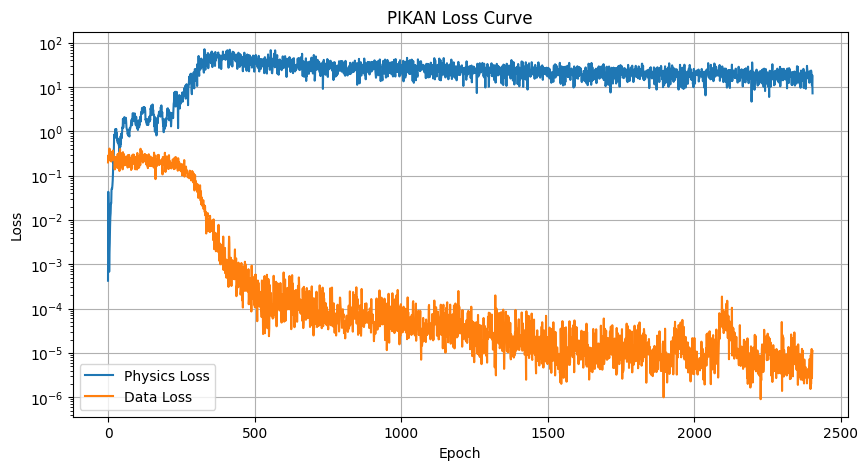

In [8]:
# plot log loss curve
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(plosses, label='Physics Loss')
ax.plot(dlosses, label='Data Loss')

plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('PIKAN Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

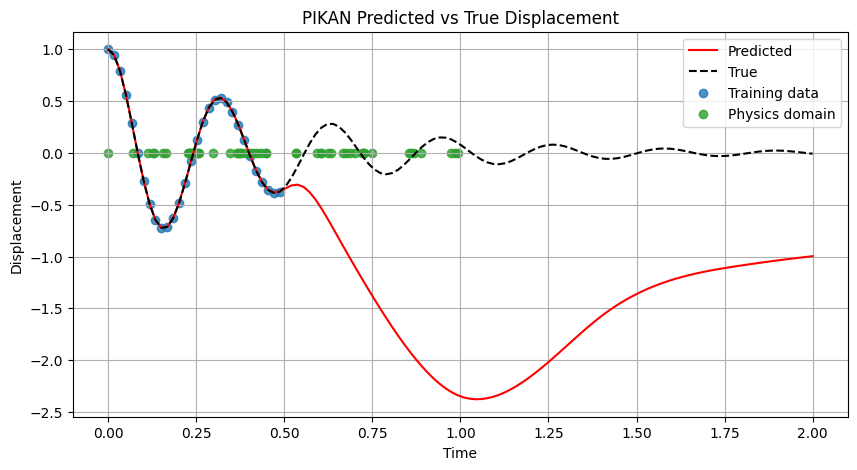

In [9]:
#plot predicted vs true displacement
model.eval()
td = torch.linspace(0, 2, 120).reshape(-1, 1).requires_grad_(True)
t0 = torch.FloatTensor(1).fill_(0.0).reshape(-1, 1)
tn = torch.FloatTensor(119, 1).uniform_(0, 2)
# tL = torch.FloatTensor(1).fill_(2.0).reshape(-1, 1)
tp = torch.concat([t0, tn])
x = model(td).squeeze().detach().numpy()
x_true = oscillator(d, w0, td).squeeze().detach().numpy()

td = td.squeeze().detach().numpy()
data_domain_mask = td<=0.5
physics_domain_mask = tp<=1.0



fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(td, x, color="red", label='Predicted')
ax.plot(td, x_true, color="black", linestyle='--', label='True')
plt.scatter(td[data_domain_mask], x_true[data_domain_mask], color="tab:blue", alpha=0.8, label="Training data")
plt.scatter(tp[physics_domain_mask], 0*tp[physics_domain_mask], color="tab:green", alpha=0.8, label="Physics domain")
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.title('PIKAN Predicted vs True Displacement')
plt.legend()
plt.grid(True)
plt.show()